## 範例重點

* 了解如何在 Keras 中，加入正規化
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD
from keras.regularizers import l2
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, regularizer_clz, regularizer_params, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=256, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, regularizer_param in enumerate(regularizer_params):
        print('Experiment with {} regularizer: {}'.format(
            regularizer_clz.__name__, ', '.join(['{} = {:.1E}'.format(k, v) for k, v in regularizer_param.items()])))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers, regularizer_clz, regularizer_param)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, regularizer_clz, regularizer_param):
    main_input = hidden_input = Input(shape=input_shape, name='main_input')
    for i, neuron_number in enumerate(neuron_numbers):
        hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}',
                             kernel_regularizer=regularizer_clz(**regularizer_param))(hidden_input)
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, regularizer_params):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], regularizer_params[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, regularizer_param):
    label = ', '.join(['{}={:.1E}'.format(k, v) for k, v in regularizer_param.items()])
    plt.plot(train_history.history[train_name], '-', label='exp: {}'.format(label), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp: {}'.format(label), color=color)

## 訓練模型

In [7]:
## 設定超參數
regularizer_clz = l2
regularizer_params = [{'l': ratio} for ratio in (1e-2, 1e-4, 1e-8, 1e-12,)]

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, regularizer_clz, regularizer_params)

Experiment with l2 regularizer: l = 1.0E-02
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 14s - loss: 15.1173 - ac

Epoch 22/50
 - 14s - loss: 1.3885 - acc: 0.5612 - val_loss: 1.5215 - val_acc: 0.5099
Epoch 23/50
 - 14s - loss: 1.3754 - acc: 0.5659 - val_loss: 1.4975 - val_acc: 0.5174
Epoch 24/50
 - 14s - loss: 1.3616 - acc: 0.5706 - val_loss: 1.4904 - val_acc: 0.5219
Epoch 25/50
 - 14s - loss: 1.3461 - acc: 0.5765 - val_loss: 1.5115 - val_acc: 0.5171
Epoch 26/50
 - 14s - loss: 1.3320 - acc: 0.5816 - val_loss: 1.4998 - val_acc: 0.5177
Epoch 27/50
 - 14s - loss: 1.3224 - acc: 0.5844 - val_loss: 1.4725 - val_acc: 0.5282
Epoch 28/50
 - 14s - loss: 1.3054 - acc: 0.5917 - val_loss: 1.4800 - val_acc: 0.5223
Epoch 29/50
 - 14s - loss: 1.2907 - acc: 0.5945 - val_loss: 1.5351 - val_acc: 0.5107
Epoch 30/50
 - 14s - loss: 1.2786 - acc: 0.5982 - val_loss: 1.4911 - val_acc: 0.5260
Epoch 31/50
 - 14s - loss: 1.2660 - acc: 0.6045 - val_loss: 1.5700 - val_acc: 0.5023
Epoch 32/50
 - 14s - loss: 1.2568 - acc: 0.6066 - val_loss: 1.4801 - val_acc: 0.5316
Epoch 33/50
 - 14s - loss: 1.2420 - acc: 0.6119 - val_loss: 1.466

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 14s - loss: 2.0275 - acc: 0.2817 - val_loss: 1.8551 - val_acc: 0.3484
Epoch 2/50
 - 14s - loss: 1.8000 - acc: 0.3721 - val_loss: 1.7497 - val_acc: 0.3917
Epoch 3/50
 - 15s - loss: 1.7145 - acc: 0.4028 - val_loss: 1.6857 - val_acc: 0.4108
Epoch 4/50
 - 14s - loss: 1.6554 - acc: 0.4213 - val_loss: 1.6351 - val_acc: 0.4266
Epoch 5/50
 - 14s - loss: 1.6075 - acc: 0.4380 - val_loss: 1.6048 - val_acc: 0.4370
Epoch 6/50
 - 14s - loss: 1.5684 - acc: 0.4514 - val_loss: 1.5680 - val_acc: 0.4502
Epoch 7/50
 - 14s - loss: 1.5362 - acc: 0.4645 - val_loss: 1.5487 - val_acc: 0.4552
Epoch 8/50
 - 14s - loss: 1.5087 - acc: 0.4721 - val_loss: 1.5184 - val_acc: 0.4642
Epoch 9/50
 - 14s - loss: 1.4815 - acc: 0.4824 - val_loss: 1.5002 - val_acc: 0.4739
Epoch 10/50
 - 13s - loss: 1.4578 - acc: 0.4899 - val_loss: 1.4874 - val_acc: 0.4781
Epoch 11/50
 - 13s - loss: 1.4341 - acc: 0.4976 - val_loss: 1.4724 - val_acc: 0.4841
Epoch 12/50
 - 13s - los

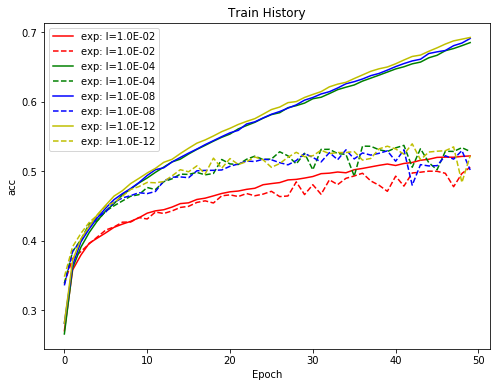

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, regularizer_params)

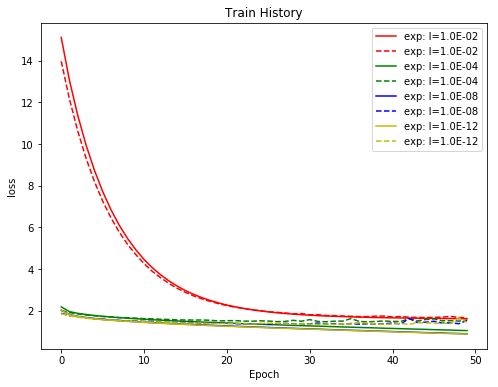

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, regularizer_params)

## 作業

請比較使用 l1, l1_l2 及不同比例下的訓練結果